In [1]:
import os # for detecting CPU cores
import configparser # to load standard config and parameters
import pandas as pd
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')
%load_ext watermark
%matplotlib inline


In [2]:
# Load external config file
config = configparser.ConfigParser()
config.read("../src/config.ini")

PATH_DATA_RAW = config["PATHS"]["PATH_DATA_RAW"]
PATH_DATA_INT = config["PATHS"]["PATH_DATA_INT"]
PATH_DATA_PRO = config["PATHS"]["PATH_DATA_PRO"]
PATH_REPORTS = config["PATHS"]["PATH_REPORTS"]
PATH_MODELS = config["PATHS"]["PATH_MODELS"]
PATH_SUB = config["PATHS"]["PATH_SUB"]

# Telegram Bot
token = config["TELEGRAM"]["token"]
chat_id = config["TELEGRAM"]["chat_id"]
FILENAME_NB = "0x_deep_learning_test" # for Telegram messages

# Set global randome state
rnd_state = 42

# Define available cpu cores
n_cpu = os.cpu_count()
print("Number of CPUs used:", n_cpu)

Number of CPUs used: 16


In [3]:
train_df = pd.read_pickle(PATH_DATA_INT+'train-opt.pkl')
test_df = pd.read_pickle(PATH_DATA_INT+'test-opt.pkl')
sample_df = pd.read_csv(PATH_DATA_RAW+'sample_submission.csv')

In [39]:
features_num = train_df.drop(['id','target'], axis=1).columns
X = train_df.drop(['id','target'], axis=1).copy()
y = train_df['target'].copy()

X_test = test_df.drop(['id'], axis=1).copy()


In [41]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer

transformer_num = make_pipeline(
    StandardScaler(),
)

preprocessor = make_column_transformer(
    (transformer_num, features_num),
)

# stratify - make sure classes are evenlly represented across splits
X_train, X_valid, y_train, y_valid = train_test_split(X, y, stratify=y, train_size=0.75)

X_train = preprocessor.fit_transform(X_train)
X_valid = preprocessor.transform(X_valid)
X_test = preprocessor.transform(X_test)

input_shape = [X_train.shape[1]]

In [91]:
import gc
from tensorflow import keras
from tensorflow.keras import layers

gc.collect()

model = keras.Sequential(
    [
        #layers.BatchNormalization(input_shape=input_shape),
        layers.Dense(4, activation="relu", input_shape=input_shape),
        layers.Dense(4, activation="relu"),
        layers.Dense(1, activation="sigmoid"),
    ]
)

model.compile(
    #optimizer="sgd",
    optimizer='adam',
    loss="binary_crossentropy",
    # metrics=['binary_accuracy'],
    metrics=["AUC"],
)

early_stopping = keras.callbacks.EarlyStopping(
    patience=20, min_delta=0.001, restore_best_weights=True,
)

history = model.fit(
    X_train,
    y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    #batch_size=1024,
    epochs=1000,
    callbacks=[early_stopping],
    verbose=0,  # hide the output because we have so many epochs
)


Best Validation Loss: 0.570882
Best Validation Accuracy: 0.754384


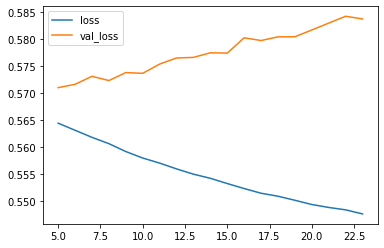

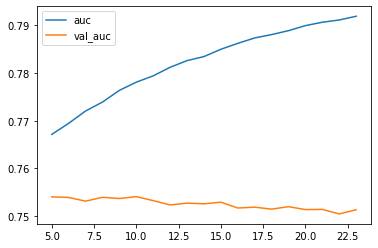

In [ ]:
history_df = pd.DataFrame(history.history)
# Start the plot at epoch 5
history_df.loc[5:, ["loss", "val_loss"]].plot()
history_df.loc[5:, ["auc", "val_auc"]].plot()

print(
    ("Best Validation Loss: {:0.6f}" + "\nBest Validation Accuracy: {:0.6f}").format(
        history_df["val_loss"].min(), history_df["val_auc"].max()
    )
)

# ADAM:
# Best Validation Loss: 0.564178
# Best Validation Accuracy: 0.757301

# SGD:
# Best Validation Loss: 0.565582
# Best Validation Accuracy: 0.750882


In [ ]:
preds_test = model.predict(X_test)

In [ ]:
from datetime import datetime

# datetime object containing current date and time
now = datetime.now()
now = now.strftime("%Y-%m-%d")

#mlflow_run_id = str(run.info.run_id)
objective = "dl_test"

curr_submission_fn = f"{now}_submission_{objective}.csv"

sample_df['target'] = preds_test
sample_df.to_csv(PATH_SUB + curr_submission_fn, index=False)

print(curr_submission_fn)

2021-11-06_submission_dl_test.csv


In [ ]:
sample_df.tail()

,id,target
539995,1139995,0.744863
539996,1139996,0.743680
539997,1139997,0.758183
539998,1139998,0.728026
539999,1139999,0.743861


In [ ]:
#!kaggle competitions submit tabular-playground-series-nov-2021 -f {PATH_SUB+curr_submission_fn} -m {curr_submission_fn}##

Successfully submitted to Tabular Playground Series - Nov 2021



  0%|          | 0.00/9.69M [00:00<?, ?B/s]
  0%|          | 8.00k/9.69M [00:00<03:14, 52.2kB/s]
  1%|          | 88.0k/9.69M [00:00<00:26, 384kB/s] 
  2%|▏         | 192k/9.69M [00:00<00:15, 632kB/s] 
  4%|▎         | 360k/9.69M [00:00<00:10, 942kB/s]
  5%|▍         | 456k/9.69M [00:00<00:14, 673kB/s]
  5%|▌         | 536k/9.69M [00:00<00:18, 531kB/s]
  6%|▌         | 600k/9.69M [00:01<00:19, 496kB/s]
  7%|▋         | 656k/9.69M [00:01<00:20, 458kB/s]
  7%|▋         | 712k/9.69M [00:01<00:21, 431kB/s]
  8%|▊         | 760k/9.69M [00:01<00:22, 418kB/s]
  8%|▊         | 808k/9.69M [00:01<00:23, 396kB/s]
  9%|▊         | 848k/9.69M [00:01<00:23, 395kB/s]
  9%|▉         | 888k/9.69M [00:01<00:23, 391kB/s]
  9%|▉         | 928k/9.69M [00:02<00:23, 386kB/s]
 10%|▉         | 968k/9.69M [00:02<00:59, 155kB/s]
 12%|█▏        | 1.16M/9.69M [00:02<00:22, 400kB/s]
 13%|█▎        | 1.23M/9.69M [00:03<00:22, 393kB/s]
 13%|█▎        | 1.29M/9.69M [00:03<00:22, 392kB/s]
 14%|█▍        | 1.34M/9.69M 